# Assessing parameter estimation methods

This example shows how `micromodelsim` can be used to assess model parameter estimation methods. One way to do it is as follows:

1. Define the simulated microstructure.
2. Simulated signals.
3. Estimate parameters from the simulated signals.
4. Compare the parameter estimates from step 3 to their ground-truth values defined in step 1.

This simple example focuses on a parameter estimation method known as the "spherical mean technique" (SMT) by [Kaden et al](https://doi.org/10.1002/mrm.25734). Specifically, we'll use SMT to estimate the parameters of a single-compartment model and evaluate its accuracy assuming that the single-compartment model perfectly captures the underlying microstructure (which obviously isn't true when analyzing real neuroimaging data).

Let's start by importing the required packages.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.special import erf

import micromodelsim as mmsim

## Acquisition protocol

The code below defines a two-shell protocol using the directions included in `micromodelsim`.

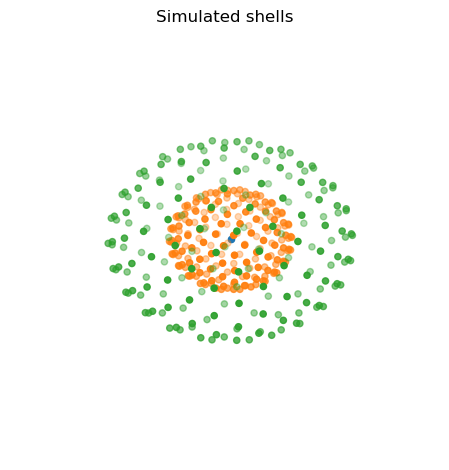

In [7]:
vertices_fname = os.path.join(
    os.path.dirname(mmsim.__file__), "healpix", "vertices_192.txt"
)
vertices = np.loadtxt(
    vertices_fname
)  # 192 directions uniformly distributed over the surface of a sphere

bvals = np.concatenate(
    (np.zeros(1), np.ones(len(vertices)), 2 * np.ones(len(vertices)))
)  # b0 and two non-zero b-values
bvecs = np.vstack((np.zeros((1, 3)), vertices, vertices))

gradient = mmsim.Gradient(bvals, bvecs)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for idx in gradient.shell_idx_list:
    ax.scatter(
        bvals[idx] * bvecs[idx, 0],
        bvals[idx] * bvecs[idx, 1],
        bvals[idx] * bvecs[idx, 2],
    )
ax.set_axis_off()
ax.set_title("Simulated shells")
fig.tight_layout()
plt.show()

# Simulated microstructure

For this example, let's fix the isotropic diffusivity to be $D = 1$ and vary the normalized anisotropy ($\Delta$) between 0.05 and 0.95. Axial and radial diffusivities of the compartment are $D(1 + 2\Delta)$ and $D(1-\Delta)$, respectively. We'll use $10^3$ of the $10^5$ example orientation distribution functions (ODFs) included in `micromodelsim` and simulate every anisotropy value for every ODF. This gives us a total of $10^4$ microstructural configurations, defined below.

In [3]:
deltas = np.linspace(0.05, 0.95, 10)  # normalized anisotropy values

realistic_odfs_sh = np.loadtxt("/home/leevi/UCL/odfs_sh.txt")[0:int(1e3)]
n_coeffs = realistic_odfs_sh.shape[1]

n_simulations = len(deltas) * len(realistic_odfs_sh)
n_compartments = 1

fs = np.ones((n_simulations, n_compartments))
ads = (
    1
    + 2 * np.concatenate([deltas for i in range(len(realistic_odfs_sh))])[:, np.newaxis]
)
rds = 1 - np.concatenate([deltas for i in range(len(realistic_odfs_sh))])[:, np.newaxis]
odfs_sh = realistic_odfs_sh[
    np.concatenate(
        [np.ones(len(deltas)).astype(int) * i for i in range(len(realistic_odfs_sh))]
    )
]

## Signal generation

Now that we have defined the simulated acquisition protocol (`gradient`) and the simulated microstructure (`fs`, `ads`, `rds`, and `odfs_sh`), signals can be simulated as follows:

In [4]:
signals = mmsim.compartment_model_simulation(gradient, fs, ads, rds, odfs_sh)

## Parameter estimation

Now we can estimate the parameters from the simulated signals using SMT and compare the estimates to the ground-truth values. Model details can be found in the paper by [Kaden et al](https://doi.org/10.1002/mrm.25734).

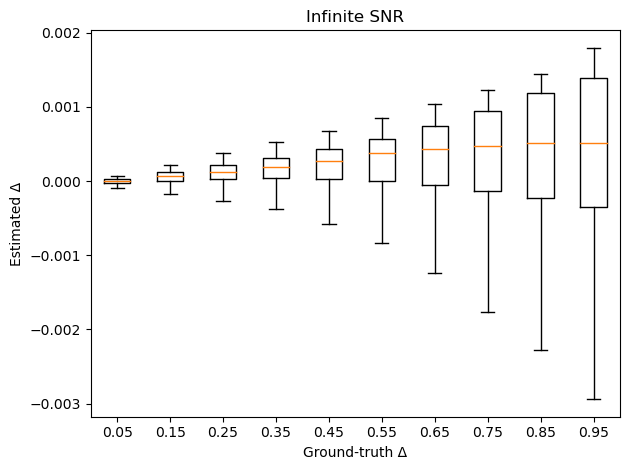

In [5]:
def signal_model(x, bs):
    return (
        np.exp(-bs * x[1])
        * np.sqrt(np.pi)
        * erf(np.sqrt(bs * (x[0] - x[1])))
        / (2 * np.sqrt(bs * (x[0] - x[1])))
    )


def residuals(x, pa_signals, bs):
    return pa_signals - signal_model(x, bs)


pa_signals = np.stack(
    [np.mean(signals[..., idx], axis=-1) for idx in gradient.shell_idx_list], axis=-1
)  # the powder-averaged signals (i.e., the spherical mean)

params = np.zeros((len(pa_signals), 2))
for i in range(len(pa_signals)):
    results = least_squares(
        fun=residuals,
        x0=np.array([1.01, 0.99]),
        args=(pa_signals[i], np.concatenate([np.ones(1) * 1e-6, gradient.bs[1::]])),
        bounds=([0, 0], [3, 3]),
    )
    params[i] = results.x

estimated_deltas = (params[:, 0] - params[:, 1]) / 3
gt_deltas = (ads - rds)[:, 0] / 3

fig = plt.figure()
ax = fig.add_subplot()
ax.boxplot(
    [
        estimated_deltas[np.where(np.isclose(gt_deltas, i))]
        - gt_deltas[np.where(np.isclose(gt_deltas, i))]
        for i in deltas
    ],
    showfliers=False,
    widths=0.05,
    positions=deltas,
)
ax.set_xlim([0, 1])
ax.set_xticklabels(np.round(deltas, 2))
ax.set_xlabel("Ground-truth Δ")
ax.set_ylabel("Estimated Δ")
ax.set_title("Infinite SNR")
fig.tight_layout()
plt.show()

From the figure above, we can see that SMT is able to estimate the ground-truth value of Δ very well if there is no noise in data.

To get a rough estimate of how SMT performs on noisy data, we can add noise to the simulated signals and repeat the parameter estimation step. Note that in proper scientific experiments, you'll need to use much larger numbers of random sampling!

/tmp/ipykernel_126080/3671497314.py:5: RuntimeWarning: invalid value encountered in sqrt
  * erf(np.sqrt(bs * (x[0] - x[1])))
/tmp/ipykernel_126080/3671497314.py:6: RuntimeWarning: invalid value encountered in sqrt
  / (2 * np.sqrt(bs * (x[0] - x[1])))


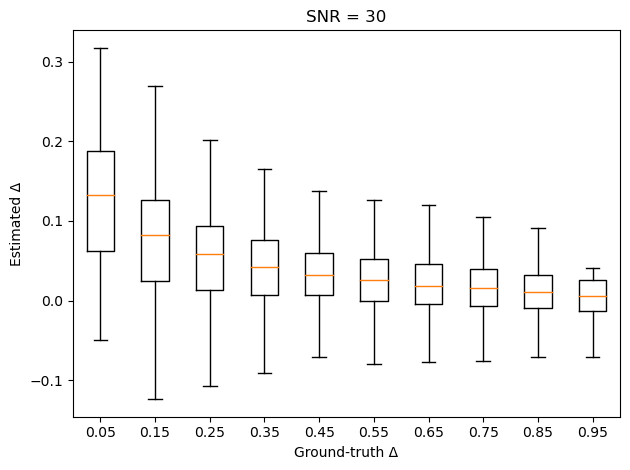

In [6]:
noisy_signals = mmsim.add_noise(signals, 30)

pa_signals = np.stack(
    [np.mean(noisy_signals[..., idx], axis=-1) for idx in gradient.shell_idx_list],
    axis=-1,
)
params = np.zeros((len(pa_signals), 2))

for i in range(len(pa_signals)):
    results = least_squares(
        fun=residuals,
        x0=np.array([1.01, 0.99]),
        args=(pa_signals[i], np.concatenate([np.ones(1) * 1e-6, gradient.bs[1::]])),
        bounds=([0, 0], [3, 3]),
    )
    params[i] = results.x

estimated_deltas = (params[:, 0] - params[:, 1]) / 3
gt_deltas = (ads - rds)[:, 0] / 3

fig = plt.figure()
ax = fig.add_subplot()
ax.boxplot(
    [
        estimated_deltas[np.where(np.isclose(gt_deltas, i))]
        - gt_deltas[np.where(np.isclose(gt_deltas, i))]
        for i in deltas
    ],
    showfliers=False,
    widths=0.05,
    positions=deltas,
)
ax.set_xlim([0, 1])
ax.set_xticklabels(np.round(deltas, 2))
ax.set_xlabel("Ground-truth Δ")
ax.set_ylabel("Estimated Δ")
ax.set_title("SNR = 30")
fig.tight_layout()
plt.show()